<a href="https://colab.research.google.com/github/nv-hiep/Autoencoders/blob/main/Variational_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Reshape, Input
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, Dropout, ActivityRegularization
from keras.layers import LSTM, RepeatVector, TimeDistributed, GaussianNoise

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap='binary')
    # plt.axis('off')

# Autoencoder

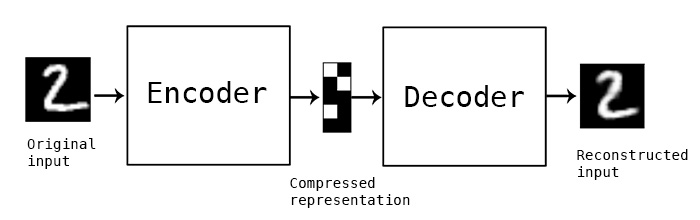

# Data

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
X_train_full = X_train_full / 255.
X_test       = X_test / 255.

In [ ]:
print('X_train_full.shape: ', X_train_full.shape)
print('y_train_full.shape: ', y_train_full.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train_full.shape:  (60000, 28, 28)
y_train_full.shape:  (60000,)
X_test.shape:  (10000, 28, 28)
y_test.shape:  (10000,)


In [ ]:
train_size = 50_000

In [ ]:
X_train = X_train_full[:train_size]
X_valid = X_train_full[train_size:]

y_train = y_train_full[:train_size]
y_valid = y_train_full[train_size:]

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_valid.shape: ', X_valid.shape)
print('y_valid.shape: ', y_valid.shape)

X_train.shape:  (50000, 28, 28)
y_train.shape:  (50000,)
X_valid.shape:  (10000, 28, 28)
y_valid.shape:  (10000,)


In [ ]:
def show_reconstructions(model, images=X_test, n_images=5):
  '''
  First row: real images
  Second row: reconstructed images
  '''
  reconstructions = model.predict(images[:n_images])

  plt.figure(figsize=(n_images * 1.5, 3))
  # plt.title('Image reconstruction from Stacked Autoencoder')
  for img_id in range(n_images):
    plt.subplot(2, n_images, 1 + img_id)
    plot_image(images[img_id])
    plt.subplot(2, n_images, 1 + n_images + img_id)
    plot_image(reconstructions[img_id])
  plt.show()

Let's create a couple functions to print nice activation histograms:

In [ ]:
def plot_percent_hist(ax, data, bins):
  counts, _ = np.histogram(data, bins=bins)
  widths = bins[1:] - bins[:-1]
  x = bins[:-1] + widths / 2
  ax.bar(x, counts / len(data), width=widths*0.8)
  ax.xaxis.set_ticks(bins)
  ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, position: "{}%".format(int(np.round(100 * y)))))
  ax.grid(True)

In [ ]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
  X_valid_codings = encoder(X_valid).numpy()
  activation_means = X_valid_codings.mean(axis=0)
  mean = activation_means.mean()
  bins = np.linspace(0, 1, n_bins + 1)

  fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
  plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
  ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
  ax1.legend(loc="upper center", fontsize=14)
  ax1.set_xlabel("Activation")
  ax1.set_ylabel("% Activations")
  ax1.axis([0, 1, 0, height])
  plot_percent_hist(ax2, activation_means, bins)
  ax2.plot([mean, mean], [0, height], "k--")
  ax2.set_xlabel("Neuron Mean Activation")
  ax2.set_ylabel("% Neurons")
  ax2.axis([0, 1, 0, height])

# Variational Autoencoder

Another important category of autoencoders was introduced in 2013 by Diederik Kingma and Max Welling and quickly became one of the most popular types of autoencoders: variational autoencoders.

They are quite different from all the autoencoders we have discussed so far, in these particular ways:

- They are probabilistic autoencoders, meaning that their outputs are partly determined by chance, even after training (as opposed to denoising autoencoders, which use randomness only during training).

- Most importantly, they are generative autoencoders, meaning that they can generate new instances that look like they were sampled from the training set.

Both these properties make them rather similar to RBMs ( restricted Boltzmann machine), but they are easier to train, and the sampling process is much faster (with RBMs you need to wait for the network to stabilize into a “thermal equilibrium” before you can sample a new instance). Indeed, as their name suggests, variational autoencoders perform variational Bayesian inference, which is an efficient way to perform approximate Bayesian inference.

What is a variational autoencoder? It's a type of autoencoder with added constraints on the encoded representations being learned. More precisely, it is an autoencoder that learns a latent variable model for its input data. So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. If you sample points from this distribution, you can generate new input data samples: a VAE is a "generative model".

How does a variational autoencoder work?

First, an encoder network turns the input samples x into two parameters in a latent space, which we will note z_mean and z_log_sigma.

Then, we randomly sample similar points z from the latent normal distribution that is assumed to generate the data, via z = z_mean + exp(z_log_sigma) * epsilon, where epsilon is a random normal tensor.

Finally, a decoder network maps these latent space points back to the original input data.


**So, INPUT -> ENCODER -> (Z_mean, Z_log_sigma) -> Latent Normal Distribution (z = z_mean + exp(z_log_sigma) * epsilon) -> Decoder -> reconstructed data**

The parameters of the model are trained via two loss functions: a reconstruction loss forcing the decoded samples to match the initial inputs (just like in our previous autoencoders), and the KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term. You could actually get rid of this latter term entirely, although it does help in learning well-formed latent spaces and reducing overfitting to the training data.

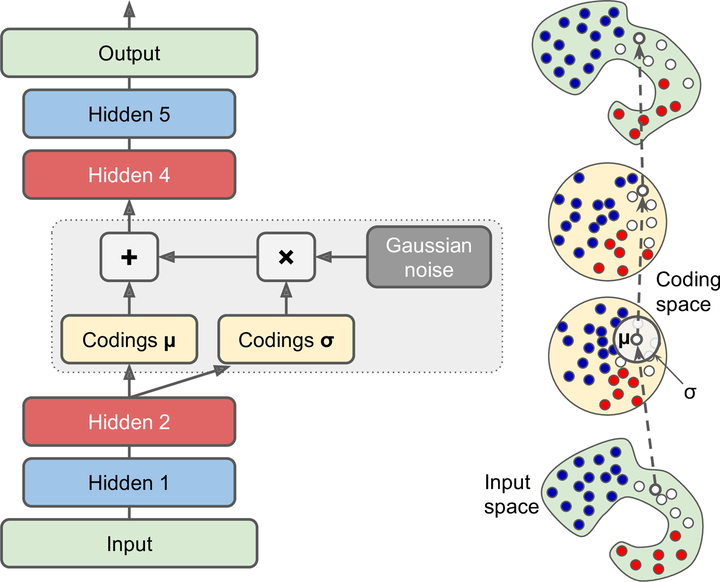

Let’s start building a variational autoencoder for Fashion MNIST. First, we will need a custom layer to sample the codings, given μ and γ:

In [ ]:
class Sampling(keras.layers.Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

This Sampling layer takes two inputs: mean (μ) and log_var (γ). It uses the function K.random_normal() to sample a random vector (of the same shape as γ) from the Normal distribution, with mean 0 and standard deviation 1. Then it multiplies it by exp(γ / 2) (which is equal to σ, as you can verify because γ = log(σ**2)), and finally it adds μ and returns the result. This samples a codings vector from the Normal distribution with mean μ and standard deviation σ.

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = Input(shape=[28, 28])
z = Flatten()(inputs)
z = Dense(150, activation='selu')(z)
z = Dense(100, activation='selu')(z)
codings_mean = Dense(codings_size)(z)
codings_log_var = Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = Input(shape=[codings_size])
x = Dense(100, activation='selu')(decoder_inputs)
x = Dense(150, activation='selu')(x)
x = Dense(28 * 28, activation='sigmoid')(x)
outputs = Reshape([28, 28])(x)
variational_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)

variational_ae.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['binary_accuracy'])

In [ ]:
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128, validation_data=(X_valid, X_valid))

Epoch 1/25
391/391 [==============================] - 5s 7ms/step - loss: 0.4484 - binary_accuracy: 0.4794 - val_loss: 0.3633 - val_binary_accuracy: 0.5014
Epoch 2/25
391/391 [==============================] - 2s 5ms/step - loss: 0.3487 - binary_accuracy: 0.5028 - val_loss: 0.3367 - val_binary_accuracy: 0.5001
Epoch 3/25
391/391 [==============================] - 2s 5ms/step - loss: 0.3356 - binary_accuracy: 0.5048 - val_loss: 0.3429 - val_binary_accuracy: 0.5034
Epoch 4/25
391/391 [==============================] - 2s 6ms/step - loss: 0.3293 - binary_accuracy: 0.5059 - val_loss: 0.3285 - val_binary_accuracy: 0.5024
Epoch 5/25
391/391 [==============================] - 2s 5ms/step - loss: 0.3265 - binary_accuracy: 0.5053 - val_loss: 0.3299 - val_binary_accuracy: 0.5015
Epoch 6/25
391/391 [==============================] - 2s 6ms/step - loss: 0.3235 - binary_accuracy: 0.5060 - val_loss: 0.3241 - val_binary_accuracy: 0.5030
Epoch 7/25
391/391 [==============================] - 2s 6ms/ste

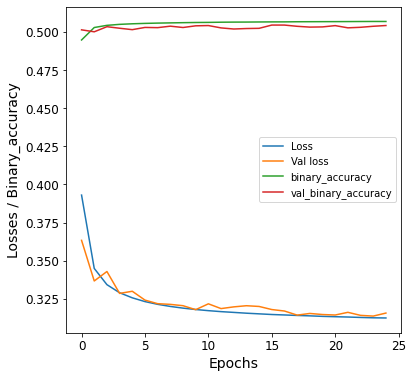

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')

plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')

plt.xlabel('Epochs')
plt.ylabel('Losses / Binary_accuracy')

plt.legend()
plt.show()

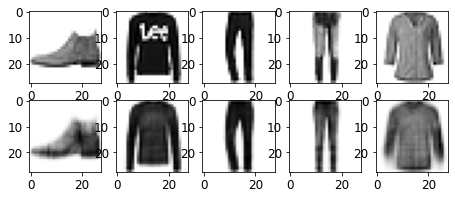

In [ ]:
# Plot the reconstructed images
show_reconstructions(variational_ae, images=X_test)
plt.show()

# Generating Fashion MNIST Images

Now let’s use this variational autoencoder to generate images that look like fashion items. All we need to do is sample random codings from a Gaussian distribution and decode them:

In [ ]:
def plot_multiple_images(images, n_cols=None):
  n_cols = n_cols or len(images)
  n_rows = (len(images) - 1) // n_cols + 1
  
  if images.shape[-1] == 1:
    images = np.squeeze(images, axis=-1)
  
  plt.figure(figsize=(n_cols, n_rows))
  
  for index, image in enumerate(images):
    plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

Let's generate a few random codings, decode them and plot the resulting images:

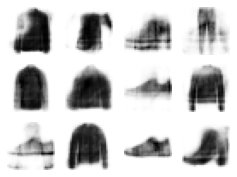

In [ ]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

Now let's perform semantic interpolation between these images:

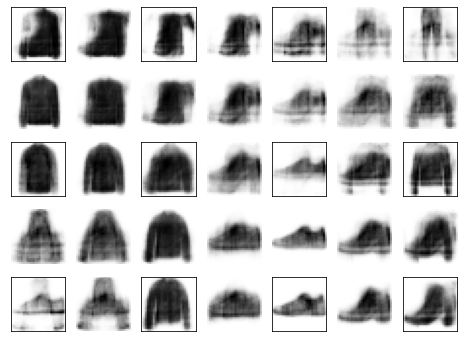

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(8, 6))
for index, image in enumerate(images):
  plt.subplot(5, 7, index + 1)
  if index%7%2==0 and index//7%2==0:
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
  else:
    plt.axis('off')
  
  plt.imshow(image, cmap='binary')
plt.show()  

The original images are framed, and the rest are the result of semantic interpolation between the nearby images. Notice, for example, how the shoe in the fourth row and fifth column is a nice interpolation between the two shoes located above and below it.

# Variational Autoencoder with MNIST digits

## MNIST digit dataset

We will use the original MNIST digits with shape (samples, 3, 28, 28), and we will just normalize pixel values between 0 and 1.

In [85]:
import keras
from keras import Model
from keras import backend as K
from keras.layers import Lambda, Input, Dense, Flatten, Reshape

In [86]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [88]:
print('X_train_full.shape: ', x_train.shape)
print('y_train_full.shape: ', y_train.shape)
print('X_test.shape: ', x_test.shape)
print('y_test.shape: ', y_test.shape)

X_train_full.shape:  (60000, 784)
y_train_full.shape:  (60000,)
X_test.shape:  (10000, 784)
y_test.shape:  (10000,)


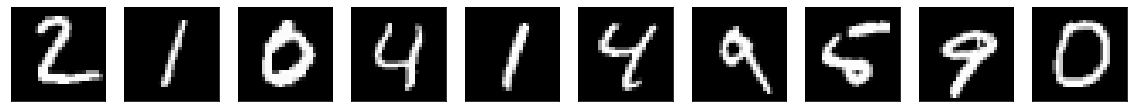

In [89]:
# Plot some samples
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
  # Display original
  ax = plt.subplot(1, n, i)
  plt.imshow(x_test[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Model

First, here's our encoder network, mapping inputs to our latent distribution parameters:

In [90]:
tf.random.set_seed(42)
np.random.seed(42)

original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(inputs)

# Coding mean
z_mean = Dense(latent_dim)(h)
# Coding sigma
z_log_sigma = Dense(latent_dim)(h)

We can use these parameters to sample new similar points from the latent space:

In [91]:
def sampling(args):
  z_mean, z_log_sigma = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=0.1)
  return z_mean + K.exp(z_log_sigma) * epsilon

z = Lambda(sampling)([z_mean, z_log_sigma])

In [92]:
# Create encoder
encoder = Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

In [93]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 64)           50240       input_5[0][0]                    
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 2)            130         dense_17[0][0]                   
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 2)            130         dense_17[0][0]                   
____________________________________________________________________________________________

In [94]:
# Create decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

In [95]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_21 (Dense)             (None, 784)               50960     
Total params: 51,152
Trainable params: 51,152
Non-trainable params: 0
_________________________________________________________________


In [96]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2]) # encoder(inputs) -> [z_mean, z_log_sigma, z]
vae = Model(inputs, outputs, name='vae_mlp')

In [97]:
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 50500     
_________________________________________________________________
decoder (Functional)         (None, 784)               51152     
Total params: 101,652
Trainable params: 101,652
Non-trainable params: 0
_________________________________________________________________


What we've done so far allows us to instantiate 3 models:

- an end-to-end autoencoder mapping inputs to reconstructions
- an encoder mapping inputs to the latent space
- a generator that can take points on the latent space and will output the corresponding reconstructed samples.

We train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.

In [98]:
# reconstruction loss
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim

# KL divergence regularization term
kl_loss = 1. + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

# Sum of the losses
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

# Compile
vae.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [99]:
history = vae.fit(x_train, x_train, epochs=100, batch_size=32, validation_data=(x_test, x_test))

Epoch 1/100
1875/1875 [==============================] - 7s 3ms/step - loss: 221.2878 - binary_accuracy: 0.7863 - val_loss: 169.5590 - val_binary_accuracy: 0.7953
Epoch 2/100
1875/1875 [==============================] - 5s 3ms/step - loss: 168.4813 - binary_accuracy: 0.7967 - val_loss: 164.2025 - val_binary_accuracy: 0.7936
Epoch 3/100
1875/1875 [==============================] - 5s 3ms/step - loss: 163.5482 - binary_accuracy: 0.7956 - val_loss: 161.0698 - val_binary_accuracy: 0.7949
Epoch 4/100
1875/1875 [==============================] - 5s 3ms/step - loss: 161.1396 - binary_accuracy: 0.7950 - val_loss: 159.2916 - val_binary_accuracy: 0.7950
Epoch 5/100
1875/1875 [==============================] - 5s 3ms/step - loss: 158.5723 - binary_accuracy: 0.7962 - val_loss: 157.7798 - val_binary_accuracy: 0.7952
Epoch 6/100
1875/1875 [==============================] - 5s 3ms/step - loss: 157.9943 - binary_accuracy: 0.7954 - val_loss: 156.8586 - val_binary_accuracy: 0.7958
Epoch 7/100
1875/1875 

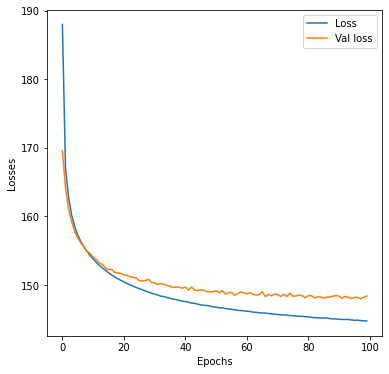

In [106]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')

plt.xlabel('Epochs')
plt.ylabel('Losses')

plt.legend()
plt.show()

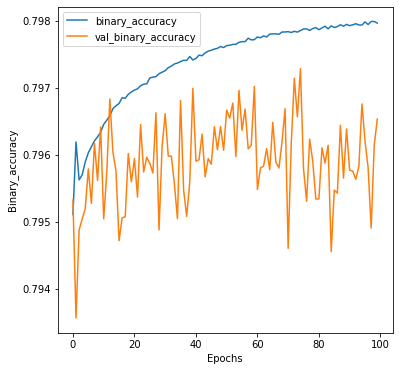

In [107]:
plt.figure(figsize=(6,6))
plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')

plt.xlabel('Epochs')
plt.ylabel('Binary_accuracy')

plt.legend()
plt.show()

## Results

In [117]:
# Predict using X_test
batch_size = 32
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

In [119]:
x_test_encoded

[array([[ 4.5468339e-01,  4.1556555e-01],
        [-3.5814008e-01, -5.2490062e-01],
        [ 2.4127141e-01,  2.0296202e+00],
        ...,
        [ 3.2486257e-01,  3.4828931e-01],
        [-3.8873911e-02,  2.9483110e-02],
        [ 4.6887994e-04, -3.9407903e-01]], dtype=float32),
 array([[-1.73756   , -1.7810568 ],
        [-1.7306879 , -1.695294  ],
        [-1.214038  , -0.57768416],
        ...,
        [-1.7296172 , -1.6559169 ],
        [-1.8114954 , -1.8733994 ],
        [-1.9760715 , -1.9202133 ]], dtype=float32),
 array([[ 0.4348813 ,  0.38395005],
        [-0.34658974, -0.49875918],
        [ 0.19765961,  2.0404627 ],
        ...,
        [ 0.3265    ,  0.34868687],
        [-0.03592803,  0.01840606],
        [ 0.01936147, -0.3747835 ]], dtype=float32)]

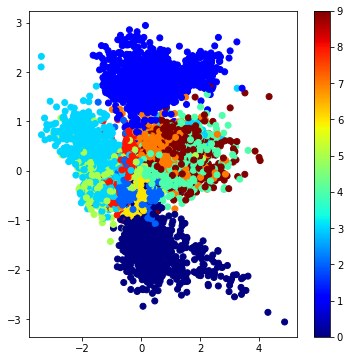

In [120]:
x_test_encoded = x_test_encoded[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='jet')
plt.colorbar()
plt.show()

In [128]:
# Predict using X_test
batch_size = 32
x_test_encoded = vae.predict(x_test, batch_size=batch_size)

In [129]:
len( x_test_encoded )

10000

In [130]:
x_test_encoded

array([[3.2088961e-13, 2.5144578e-13, 3.7544002e-13, ..., 3.9744022e-13,
        3.7776732e-13, 4.4159834e-13],
       [1.5887428e-17, 6.2111040e-17, 6.4681176e-17, ..., 7.1326474e-17,
        3.2770821e-17, 1.4883532e-16],
       [6.1007386e-24, 3.2629999e-24, 6.0453239e-24, ..., 1.3597389e-23,
        1.3139936e-23, 3.8822780e-23],
       ...,
       [2.8970725e-13, 2.9638236e-13, 4.5216966e-13, ..., 4.8601395e-13,
        4.0570130e-13, 5.6922967e-13],
       [3.7528730e-14, 8.1176012e-14, 1.1903903e-13, ..., 1.1353974e-13,
        7.0095514e-14, 1.7362513e-13],
       [6.0532443e-15, 1.7715352e-14, 1.5847353e-14, ..., 1.4900190e-14,
        8.2362358e-15, 2.4468107e-14]], dtype=float32)

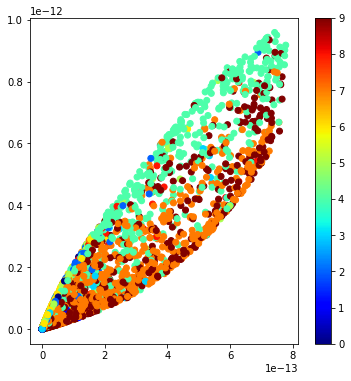

In [131]:
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='jet')
plt.colorbar()
plt.show()

Each of these colored clusters is a type of digit. Close clusters are digits that are structurally similar (i.e. digits that share information in the latent space).

Because the VAE is a generative model, we can also use it to generate new digits! Here we will scan the latent plane, sampling latent points at regular intervals, and generating the corresponding digit for each of these points. This gives us a visualization of the latent manifold that "generates" the MNIST digits.

In [147]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

In [148]:
print( grid_x.shape )
print( grid_y.shape )

(15,)
(15,)


In [149]:
for i, yi in enumerate(grid_x):
  for j, xi in enumerate(grid_y):
    z_sample = np.array([[xi, yi]])
    x_decoded = decoder.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

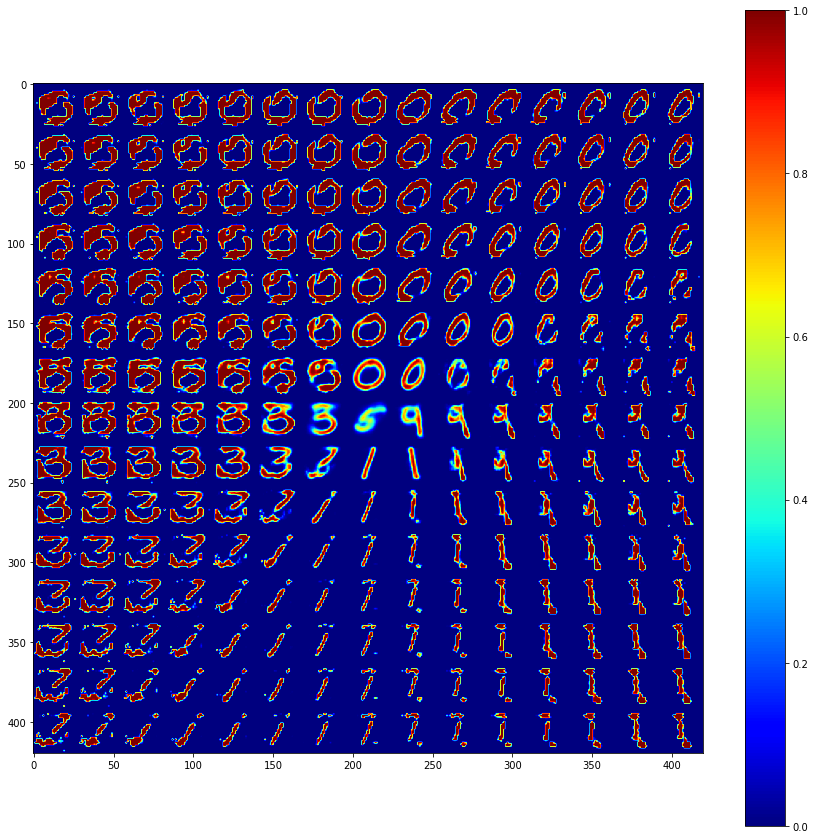

In [150]:
plt.figure(figsize=(15, 15))
plt.imshow(figure, cmap='jet')
plt.colorbar()
plt.show()